Environment Information:
* Win10 x64
* Python 3.8.8
* `pandas==1.3.2`
* `fastparquet==0.7.1`
* `matplotlib==3.3.4`

# Load Data and Preliminary Exploration

In [1]:
import pandas as pd

def CheckMissingValues(df):
    for col in df.columns:
        nNull = ((df[col]=='') | df[col].isnull()).sum()
        if nNull > 0:
            print(f"WARNING: column {col} contains {nNull} missing values.")

In [2]:
colsClicks = ['timestamp', 'user_id', 'store_id', 'device', 'platform', 'channel']
dfClicks = pd.read_parquet('data/clicks.parquet', engine='fastparquet')[colsClicks]
dfClicks['timestamp'] = pd.to_datetime(dfClicks['timestamp'])

dfClicks = dfClicks[(dfClicks['timestamp']>='2021-01-01') & (dfClicks['timestamp']<'2021-04-01')].reset_index(drop=True)
print(f"Clicks data contains {len(dfClicks)} rows from {dfClicks['user_id'].nunique()} users, {dfClicks['store_id'].nunique()} stores, {dfClicks['channel'].nunique()} channels over {dfClicks['timestamp'].min()} to {dfClicks['timestamp'].max()}")
print(f"There are {dfClicks['device'].nunique()} devices, such as {list(dfClicks['device'].value_counts().head().index)}")
print(f"There are {dfClicks['platform'].nunique()} platforms, such as {list(dfClicks['platform'].value_counts().head().index)}")
print(f"There are {dfClicks['channel'].nunique()} channels, such as {list(dfClicks['channel'].value_counts().head().index)}")
CheckMissingValues(dfClicks)
dfClicks.head(3)

Clicks data contains 1846145 rows from 103806 users, 403 stores, 55 channels over 2021-01-01 00:00:15 to 2021-03-31 00:00:00
There are 8 devices, such as ['app_android', 'app_ios', 'desktop', 'extension', 'mobile_android']
There are 4 platforms, such as ['Android App', 'iOS App', 'Web', 'Browser Extension']
There are 55 channels, such as ['paid_ins_organic', 'Direct', 'Extension', 'Paid Search', 'Display']


,timestamp,user_id,store_id,device,platform,channel
0,2021-02-03 23:47:27,28349,366,app_ios,iOS App,Direct
1,2021-03-07 15:52:05,3553,424,mobile_android,Web,Display
2,2021-03-09 13:17:56,53657,165,desktop,Web,Referral


Observation:
* Much more users then stores
* The small number of stores favors item-based collaborative filtering.
    * However in this exercise, I will try out matrix factorization based on Keras.
        * We will see that the recommendation is not well personalized for this data set.
* Concentrated categories of devices and platforms

In [3]:
colsStores = ['store_id', 'merchant_id', 'start_date', 'end_date']
dfStores = pd.read_parquet('data/stores.parquet', engine='fastparquet')[colsStores]
dfStores['start_date'] = pd.to_datetime(dfStores['start_date'])
dfStores['end_date'] = pd.to_datetime(dfStores['end_date'])
print(f"Stores data contains {len(dfStores)} rows from {dfStores['store_id'].nunique()} stores, {dfStores['merchant_id'].nunique()} marchants from {dfStores['start_date'].min().date()}")
CheckMissingValues(dfStores)
dfStores.head(3)

Stores data contains 537 rows from 537 stores, 497 marchants from 2020-03-02


,store_id,merchant_id,start_date,end_date
0,0,0,2020-07-31,2029-12-31
1,1,1,2020-03-26,2029-12-31
2,2,2,2020-03-02,2028-12-31


In [4]:
# Number of merchant per store
seNumMerchantPerStore = dfStores.groupby('store_id')['merchant_id'].nunique()
seNumMerchantPerStore.max()

1

In [5]:
dfStores['start_date'].describe(datetime_is_numeric=True)

count                              339
mean     2020-07-12 12:02:07.433628416
min                2020-03-02 00:00:00
25%                2020-04-21 00:00:00
50%                2020-05-18 00:00:00
75%                2020-08-10 00:00:00
max                2021-05-05 00:00:00
Name: start_date, dtype: object

In [6]:
dfStores['end_date'].describe(datetime_is_numeric=True)

count                              339
mean     2043-05-14 23:17:31.327433728
min                2021-05-06 00:00:00
25%                2029-12-31 00:00:00
50%                2050-04-30 00:00:00
75%                2050-07-31 00:00:00
max                2120-06-30 00:00:00
Name: end_date, dtype: object

In [7]:
(dfStores['end_date'] - dfStores['start_date']).describe()

count                             339
mean     8341 days 11:15:23.893805312
std      4847 days 04:20:14.927688064
min                   2 days 00:00:00
25%                3567 days 00:00:00
50%               10963 days 00:00:00
75%               10970 days 00:00:00
max               36553 days 00:00:00
dtype: object

Observations:
* 25% stores were not presented in the clicks data
* Each store had maximum 1 merchant (1-to-many)
* Start and End dates:
    * Some stores opened only for a very short period of time
    * Should not recommend stores which have been closed
        * In this dataset, the minimum `end_at` is 2021-05-06, so I will not handle this for this exercise.
    * Can specificly recommend newly opened stores
    * Why stores opened "in future" (after Mar 2021) could also get clicks?

# More Exploration

In [8]:
colsClicks = ['timestamp', 'user_id', 'store_id', 'device', 'platform', 'channel']
colsStores = ['store_id', 'merchant_id']
df0 = dfClicks[colsClicks].merge(dfStores[colsStores], 'left', 'store_id')

df0['yearmonth'] = df0['timestamp'].dt.strftime('%Y-%m')

df0.sample(3)

,timestamp,user_id,store_id,device,platform,channel,merchant_id,yearmonth
1841760,2021-03-11 13:31:29,210121,36,desktop,Web,Direct,36,2021-03
297397,2021-01-30 11:22:46,33193,182,app_android,Android App,paid_ins_af_banner,40,2021-01
1364109,2021-01-27 01:41:28,65141,36,desktop,Web,(Other),36,2021-01


### 1) Distribution of clicks among merchant

Top 10 merchants contributed 67.09 % of clicks
Top 20 merchants contributed 79.70 % of clicks


<AxesSubplot:>

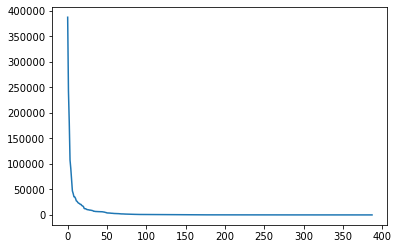

In [9]:
seMerchantClicks = df0['merchant_id'].value_counts()

# exam top 10 and top 20 stores
nClicksTotal = seMerchantClicks.sum()
nClicksTop10 = seMerchantClicks.head(10).sum()
nClicksTop20 = seMerchantClicks.head(20).sum()
print(f"Top 10 merchants contributed {(nClicksTop10/nClicksTotal)*100:.2f} % of clicks")
print(f"Top 20 merchants contributed {(nClicksTop20/nClicksTotal)*100:.2f} % of clicks")

seMerchantClicks.reset_index(drop=True).plot()

Observation:
* Very skewed, clicks were concentrated in most popular merchants

### 2) Average number of clicks per user per month

In [10]:
seUserMonthClicks = df0.groupby(['user_id','yearmonth']).size()

print(f"Number of clicks per user per month: average = {seUserMonthClicks.mean():.2f}, median = {seUserMonthClicks.median():.2f}")

Number of clicks per user per month: average = 10.11, median = 5.00


Observation:
* Some users clicked much more than others, which pulls up the average

### 3) Number of merchants clicked by each user

In [11]:
seUserMerchants = df0.groupby(['user_id'])['merchant_id'].nunique().sort_values(ascending=False)

seUserMerchants.describe()

count    103806.000000
mean          3.864256
std           4.071698
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         204.000000
Name: merchant_id, dtype: float64

In [12]:
# Top 5 users with most visited merchants
seUserMerchants.head(5)

user_id
204339    204
112508    112
82271     105
201554     76
188010     72
Name: merchant_id, dtype: int64

In [13]:
# Some users visited 5 merchants
seUserMerchants[seUserMerchants==5].head()

user_id
61496     5
67177     5
233637    5
67464     5
91134     5
Name: merchant_id, dtype: int64

In [14]:
# Some users visited only 1 merchant
seUserMerchants[seUserMerchants==1].head()

user_id
206475    1
58427     1
207596    1
218634    1
218623    1
Name: merchant_id, dtype: int64

In [15]:
# Users with at last 3 merchants clicked
# Validation of the recommender's performance will be primarily on these group of users

print(f"{(seUserMerchants>=3).sum()/len(seUserMerchants)*100:.2f}% users had clicked on at least 3 merchants.")

49.89% users had clicked on at least 3 merchants.


### 4) Distribution of users among merchant

In [16]:
seMerchantUsers = df0.groupby(['merchant_id'])['user_id'].nunique().sort_values(ascending=False)
seMerchantUsers.head(5)

merchant_id
40     38901
36     28598
398    21893
271    20730
490    19440
Name: user_id, dtype: int64

<AxesSubplot:>

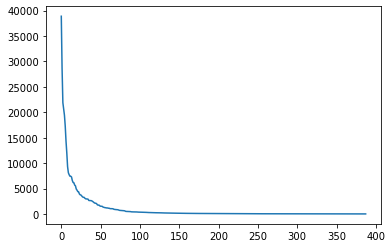

In [17]:
seMerchantUsers.reset_index(drop=True).plot()

Observation:
* Still very skewed -- though it is less skewed than clicks